In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from arviz import *

In [2]:
df = pd.read_csv("./corona_cases.txt", header=0)
#df.index = pd.to_datetime(df['Date'])
df["Tot"] = np.cumsum(df["Cases"])
df["dCases"] = df["Tot"] - df["Tot"].shift(1)
df["Growth Factor"] = df["dCases"]/df["dCases"].shift(1).where(df["dCases"]!=0)
df["log dCases"] = np.log(df["dCases"].where(df["dCases"] > 0, np.nan))
df

,Date,Cases,Tot,dCases,Growth Factor,log dCases
0,2020-02-01,1,1,NaN,NaN,NaN
1,2020-02-02,1,2,1.0,NaN,0.000000
2,2020-02-03,0,2,0.0,NaN,NaN
3,2020-02-04,0,2,0.0,NaN,NaN
4,2020-02-05,0,2,0.0,NaN,NaN
5,2020-02-06,2,4,2.0,inf,0.693147
6,2020-02-07,0,4,0.0,NaN,NaN
7,2020-02-08,1,5,1.0,inf,0.000000
8,2020-02-09,0,5,0.0,NaN,NaN
9,2020-02-10,4,9,4.0,inf,1.386294


Assuming exponential growth:

$$ \text{Cases}(t) = ae^{r t} (t \ \text{in days}) $$

$$ \log(\text{Cases})(t) = \log(a) + r t $$

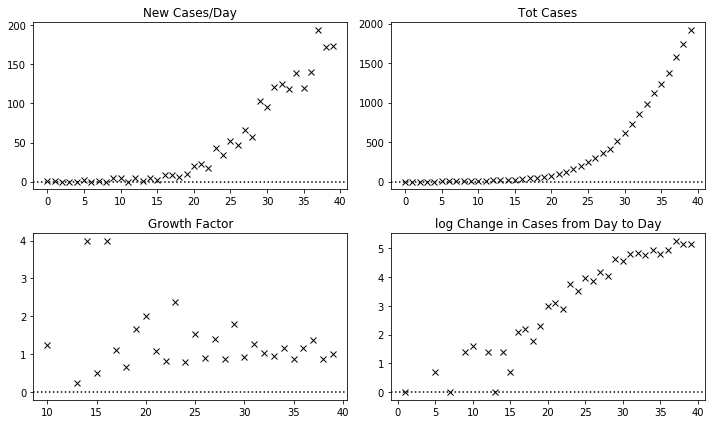

In [3]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
ax[0,0].plot(df.index, df["Cases"], c="None", marker="x", mfc="k")
ax[0,0].axhline(0, c="k", ls=":")
ax[0,0].set_title("New Cases/Day")
ax[0,1].plot(df.index, df["Tot"], c="None", marker="x", mfc="k")
ax[0,1].axhline(0, c="k", ls=":")
ax[0,1].set_title("Tot Cases")
ax[1,0].plot(df.index, df["Growth Factor"], c="None", marker="x", mfc="k")
ax[1,0].axhline(0, c="k", ls=":")
ax[1,0].set_title("Growth Factor")
ax[1,1].plot(df.index, df["log dCases"], c="None", marker="x", mfc="k")
ax[1,1].axhline(0, c="k", ls=":")
ax[1,1].set_title("log Change in Cases from Day to Day")
plt.tight_layout()

Our model for the (log) growth in the number of cases per day is going to be:

$$ \hat{y}(t) \sim \mathscr{N}(\mu, \sigma) $$

$$ \sigma \sim \mathscr{N}(0, 1.0) $$

$$ a \sim \mathscr{N}(0, 1.0) $$

$$ r \sim \text{Uniform}(0, 2.0) $$

$$ \mu = a + r * t $$

In [7]:
with pm.Model() as model:
    a = pm.Normal('a', mu=0, sigma=1.0)
    r = pm.Uniform('r', lower=0.0, upper=2.0)
    
    sigma = pm.HalfNormal('sigma', sigma=1.0)
    
    mu = pm.Deterministic('mu', a + r * df.index)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=df["log dCases"])
    
    trace = pm.sample(1000, tune=1000)

/Users/davidwych/miniconda3/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in y_hat contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_hat_missing, sigma, r, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 425.23draws/s]


/Users/davidwych/miniconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/davidwych/miniconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/davidwych/miniconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/davidwych/miniconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2d4a4710>,
      dtype=object)

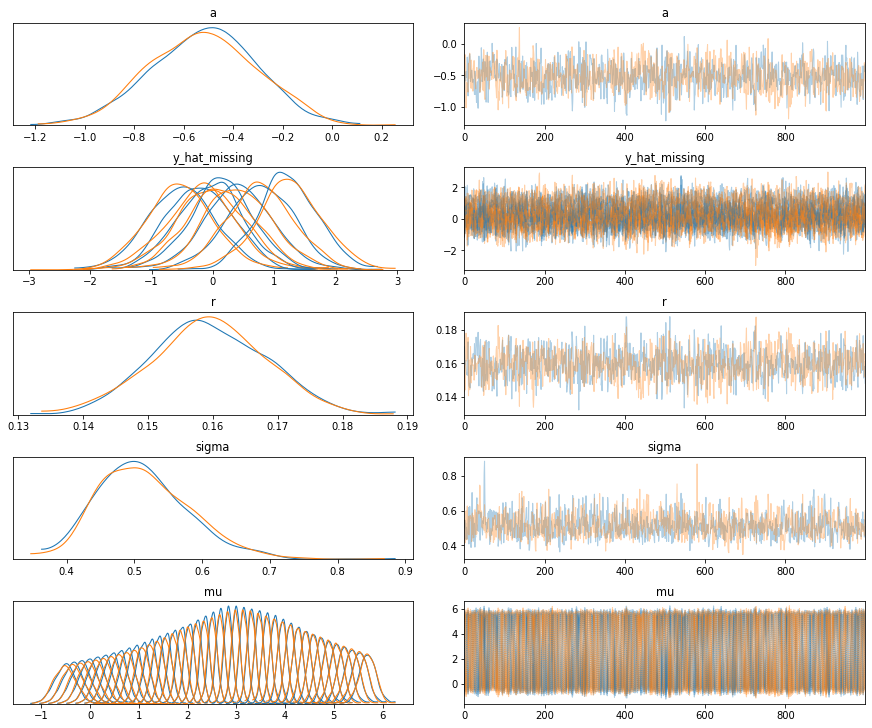

In [8]:
pm.traceplot(trace)

Estimated Doubling Time (days): 4.36


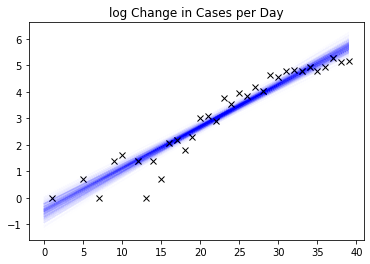

In [11]:
plt.plot(df.index, df["log dCases"], c="None", marker="x", mec="k")
growth_fac = np.zeros(1000)
for i in range(0, 1000):
    idx = np.random.randint(len(trace))
    growth_fac[i] = trace['r'][idx]
    plt.plot(df.index, trace['a'][idx] + trace['r'][idx]*df.index, c="Blue", alpha=0.005)

plt.title("log Change in Cases per Day")
doub_time = np.log(2)/np.mean(growth_fac)
#std_doub_time = np.log(2)/np.std(growth_fac)
print("Estimated Doubling Time (days): {:.2f}".format(doub_time))

Cases by end of this month: 12127


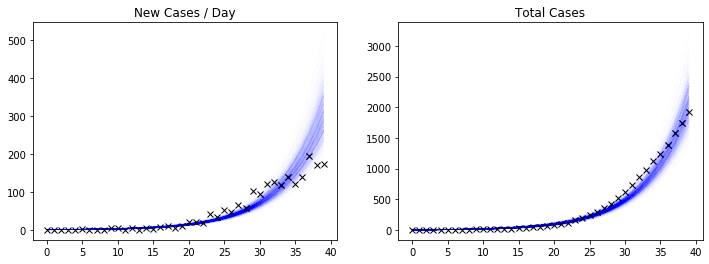

In [14]:
f, ax = plt.subplots(ncols=2, figsize=(12,4))
ax[0].plot(df.index, df["Cases"], c="None", marker="x", mec="k")
ax[1].plot(df.index, df["Tot"], c="None", marker="x", mec="k")
growth_fac = np.zeros(1000)
ampl = np.zeros(1000)
endpoints = np.zeros(1000)
for i in range(0, 1000):
    idx = np.random.randint(len(trace))
    ampl[idx] = np.exp(trace['a'][idx])
    _cases = ampl[idx]*np.exp(trace['r'][idx]*df.index)
    _accum = np.cumsum(_cases)
    _cases_ext = ampl[idx]*np.exp(trace['r'][idx]*np.arange(len(df.index)+11))
    _accum_ext = np.cumsum(_cases_ext)
    endpoints[i] = _accum_ext[-1]
    
    ax[0].plot(df.index, _cases, c="Blue", alpha=0.005)
    ax[0].set_title("New Cases / Day")
    ax[1].plot(df.index, _accum, c="Blue", alpha=0.005)
    ax[1].set_title("Total Cases")

avg_cases = np.mean(endpoints)

print("Cases by end of this month: {:.0f}".format(avg_cases))

Text(0.5, 1.0, 'Cases by the End of This Month')

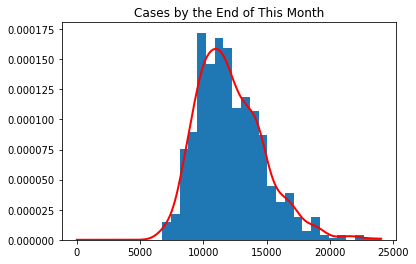

In [16]:
from scipy.stats import gaussian_kde
f, ax = plt.subplots()
n, bins, patches = ax.hist(endpoints, bins=25, density=True)
density = gaussian_kde(endpoints)
xs = np.linspace(0,bins[-1],200)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax.plot(xs, density(xs), c="Red", lw=2.0)
ax.set_title("Cases by the End of This Month")
#ax.set_xticks(np.linspace(0,2e6, 8))
#ax.set_xticklabels([str[el] for el in np.linspace(0,2e6, 8)], rotation=30)

# From COVID TRACKER

In [17]:
data = pd.read_csv("us-daily.csv")

In [18]:
data

,date,states,positive,negative,posNeg,pending,death,total
0,20200304,14,118,748,866,103,NaN,969
1,20200305,24,176,953,1129,197,NaN,1326
2,20200306,36,223,1571,1794,458,NaN,2252
3,20200307,51,341,1809,2150,602,NaN,2752
4,20200308,51,417,2335,2752,347,NaN,3099
5,20200309,51,584,3367,3951,313,NaN,4264
6,20200310,51,778,3807,4585,469,NaN,5054
7,20200311,51,1053,5978,7031,563,27.0,7617
8,20200312,51,1315,7949,9264,673,36.0,9966
9,20200313,51,1922,13613,15535,1130,39.0,16665


In [19]:
data["dpositive"] = data["positive"] - data["positive"].shift(1)

In [20]:
data["log dpositive"] = np.log(data["dpositive"])

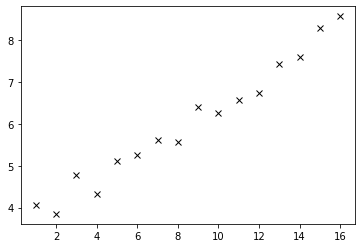

In [21]:
plt.plot(data.index, data["log dpositive"], c="None", mfc="k", marker="x")

In [22]:
data

,date,states,positive,negative,posNeg,pending,death,total,dpositive,log dpositive
0,20200304,14,118,748,866,103,NaN,969,NaN,NaN
1,20200305,24,176,953,1129,197,NaN,1326,58.0,4.060443
2,20200306,36,223,1571,1794,458,NaN,2252,47.0,3.850148
3,20200307,51,341,1809,2150,602,NaN,2752,118.0,4.770685
4,20200308,51,417,2335,2752,347,NaN,3099,76.0,4.330733
5,20200309,51,584,3367,3951,313,NaN,4264,167.0,5.117994
6,20200310,51,778,3807,4585,469,NaN,5054,194.0,5.267858
7,20200311,51,1053,5978,7031,563,27.0,7617,275.0,5.616771
8,20200312,51,1315,7949,9264,673,36.0,9966,262.0,5.568345
9,20200313,51,1922,13613,15535,1130,39.0,16665,607.0,6.408529


In [23]:
with pm.Model() as model:
    a = pm.Normal('a', mu=0, sigma=1.0)
    r = pm.Uniform('r', lower=0.0, upper=2.0)
    
    sigma = pm.HalfNormal('sigma', sigma=1.0)
    
    mu = pm.Deterministic('mu', a + r * data.index)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=data["log dpositive"])
    
    trace = pm.sample(1000, tune=1000)

/Users/davidwych/miniconda3/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in y_hat contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_hat_missing, sigma, r, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:13<00:00, 304.95draws/s]
The acceptance probability does not match the target. It is 0.8821543196617246, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/davidwych/miniconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/davidwych/miniconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/davidwych/miniconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/davidwych/miniconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2e7a3710>,
      dtype=object)

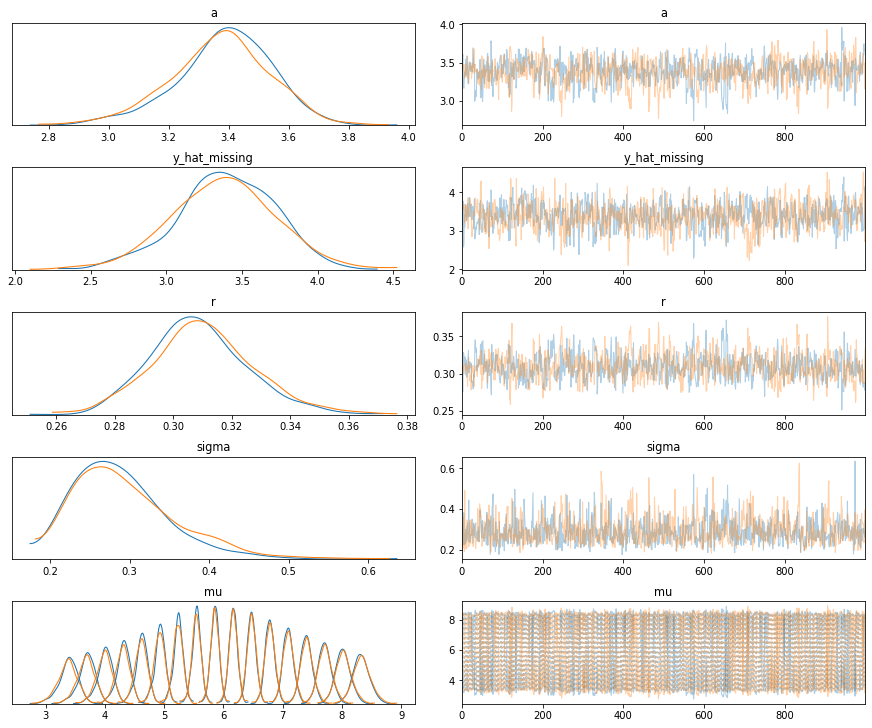

In [24]:
pm.traceplot(trace)

Estimated Doubling Time (days): 2.25


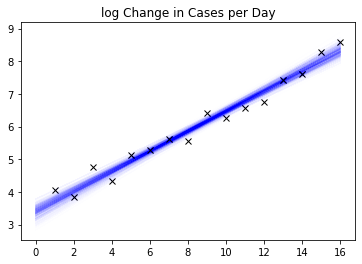

In [27]:
plt.plot(data.index, data["log dpositive"], c="None", marker="x", mec="k")
growth_fac = np.zeros(1000)
for i in range(0, 1000):
    idx = np.random.randint(len(trace))
    growth_fac[i] = trace['r'][idx]
    plt.plot(data.index, trace['a'][idx] + trace['r'][idx]*data.index, c="Blue", alpha=0.005)

plt.title("log Change in Cases per Day")
doub_time = np.log(2)/np.mean(growth_fac)
#std_doub_time = np.log(2)/np.std(growth_fac)
print("Estimated Doubling Time (days): {:.2f}".format(doub_time))

Cases by end of this month: 487756


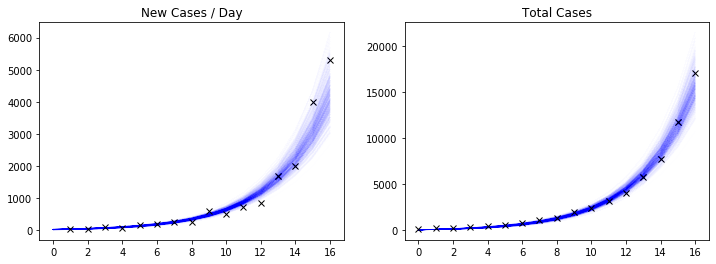

In [28]:
f, ax = plt.subplots(ncols=2, figsize=(12,4))
ax[0].plot(data.index, data["dpositive"], c="None", marker="x", mec="k")
ax[1].plot(data.index, data["positive"], c="None", marker="x", mec="k")
growth_fac = np.zeros(1000)
ampl = np.zeros(1000)
endpoints = np.zeros(1000)
for i in range(0, 1000):
    idx = np.random.randint(len(trace))
    ampl[idx] = np.exp(trace['a'][idx])
    _cases = ampl[idx]*np.exp(trace['r'][idx]*data.index)
    _accum = np.cumsum(_cases)
    _cases_ext = ampl[idx]*np.exp(trace['r'][idx]*np.arange(len(data.index)+11))
    _accum_ext = np.cumsum(_cases_ext)
    endpoints[i] = _accum_ext[-1]
    
    ax[0].plot(data.index, _cases, c="Blue", alpha=0.005)
    ax[0].set_title("New Cases / Day")
    ax[1].plot(data.index, _accum, c="Blue", alpha=0.005)
    ax[1].set_title("Total Cases")

avg_cases = np.mean(endpoints)

print("Cases by end of this month: {:.0f}".format(avg_cases))

Text(0.5, 1.0, 'Cases by the End of This Month')

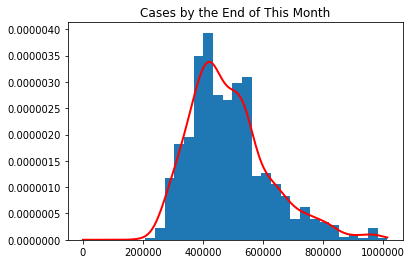

In [30]:
from scipy.stats import gaussian_kde
f, ax = plt.subplots()
n, bins, patches = ax.hist(endpoints, bins=25, density=True)
density = gaussian_kde(endpoints)
xs = np.linspace(0,bins[-1],200)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax.plot(xs, density(xs), c="Red", lw=2.0)
ax.set_title("Cases by the End of This Month")
#ax.set_xticks(np.linspace(0,2e6, 8))
#ax.set_xticklabels([str[el] for el in np.linspace(0,2e6, 8)], rotation=30)